In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import time
import pandas as pd



from absl import app
from absl import flags
import tensorflow as tf


import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

c:\Users\angga\anaconda3\envs\env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TF version: 2.6.0
Hub version: 0.8.0


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

print('Num Gpu Avaible' ,len(physical_devices))

Num Gpu Avaible 1


In [6]:
tf.test.is_built_with_cuda

<function tensorflow.python.platform.test.is_built_with_cuda()>

In [7]:
import sys
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [8]:
train_dir = 'classification/train'
test_dir = 'classification/test'
validation_dir = 'classification/val'


BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset  = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       shuffle=True,
                                                            image_size=IMG_SIZE,
                                                            batch_size=BATCH_SIZE
                                                            )

validation_dataset   = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)


test_dataset  = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)                                                               

Found 45095 files belonging to 102 classes.
Found 7508 files belonging to 102 classes.
Found 22619 files belonging to 102 classes.


In [11]:
f = open('classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer
...,...,...
97,98,Chlumetia transversa
98,99,Mango flat beak leafhopper
99,100,Rhytidodera bowrinii white
100,101,Sternochetus frigidus


In [60]:
class_names = np.array(classes.name)
print(class_names)

['rice leaf roller' 'rice leaf caterpillar' 'paddy stem maggot'
 'asiatic rice borer' 'yellow rice borer' 'rice gall midge' 'Rice Stemfly'
 'brown plant hopper' 'white backed plant hopper'
 'small brown plant hopper' 'rice water weevil' 'rice leafhopper'
 'grain spreader thrips' 'rice shell pest' 'grub' 'mole cricket'
 'wireworm' 'white margined moth' 'black cutworm' 'large cutworm'
 'yellow cutworm' 'red spider' 'corn borer' 'army worm' 'aphids'
 'Potosiabre vitarsis' 'peach borer' 'english grain aphid' 'green bug'
 'bird cherry-oataphid' 'wheat blossom midge' 'penthaleus major'
 'longlegged spider mite' 'wheat phloeothrips' 'wheat sawfly'
 'cerodonta denticornis' 'beet fly' 'flea beetle' 'cabbage army worm'
 'beet army worm' 'Beet spot flies' 'meadow moth' 'beet weevil'
 'sericaorient alismots chulsky' 'alfalfa weevil' 'flax budworm'
 'alfalfa plant bug' 'tarnished plant bug' 'Locustoidea' 'lytta polita'
 'legume blister beetle' 'blister beetle' 'therioaphis maculata Buckton'
 'odont

In [45]:
mobilenet_v3 ="https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

feature_extractor_model  = mobilenet_v3

In [46]:
do_fine_tuning = True #@param {type:"boolean"}

In [47]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=do_fine_tuning)

In [48]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = validation_dataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [49]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [78]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [51]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [52]:
num_classes = len(classes.name)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              4226432   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               130662    
Total params: 4,357,094
Trainable params: 4,332,694
Non-trainable params: 24,400
_________________________________________________________________


In [53]:
predictions = model(image_batch)

In [54]:
predictions.shape

TensorShape([32, 102])

In [55]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [56]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                   )

Epoch 1/10


c:\Users\angga\anaconda3\envs\env\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1410/1410 [==============================] - 280s 192ms/step - loss: 2.4574 - accuracy: 0.4597 - val_loss: 2.1546 - val_accuracy: 0.5101
Epoch 2/10
1410/1410 [==============================] - 388s 274ms/step - loss: 1.8183 - accuracy: 0.5913 - val_loss: 2.1368 - val_accuracy: 0.5456
Epoch 3/10
1410/1410 [==============================] - 366s 260ms/step - loss: 1.5687 - accuracy: 0.6564 - val_loss: 2.1284 - val_accuracy: 0.5607
Epoch 4/10
1410/1410 [==============================] - 367s 261ms/step - loss: 1.4130 - accuracy: 0.7037 - val_loss: 2.2326 - val_accuracy: 0.5791
Epoch 5/10
1410/1410 [==============================] - 359s 255ms/step - loss: 1.2866 - accuracy: 0.7478 - val_loss: 2.3302 - val_accuracy: 0.5844
Epoch 6/10
1410/1410 [==============================] - 371s 263ms/step - loss: 1.2120 - accuracy: 0.7807 - val_loss: 2.4846 - val_accuracy: 0.5753
Epoch 7/10
1410/1410 [==============================] - 399s 283ms/step - loss: 1.1555 - accuracy: 0.8035 - val_loss: 2.558

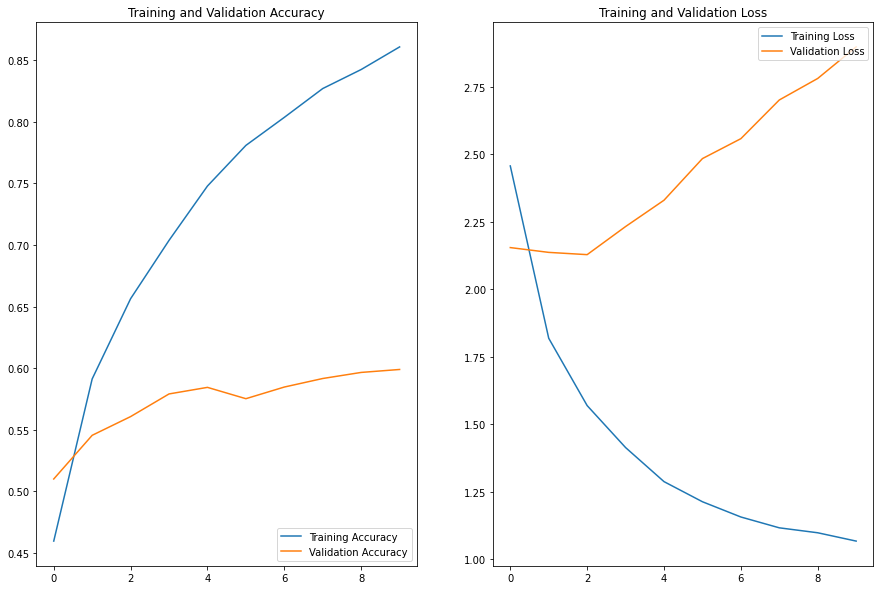

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

707/707 - 35s - loss: 74946072.0000 - accuracy: 0.0153


In [88]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['Tetradacus c Bactrocera minax' 'Parlatoria zizyphus Lucus'
 'Adristyrannus' 'small brown plant hopper' 'yellow rice borer'
 'Deporaus marginatus Pascoe' 'grub' 'Adristyrannus' 'large cutworm'
 'Panonchus citri McGregor' 'Ampelophaga' 'lytta polita'
 'white margined moth' 'lytta polita' 'Adristyrannus' 'Adristyrannus'
 'yellow rice borer' 'large cutworm' 'Cicadella viridis'
 'Salurnis marginella Guerr' 'Parlatoria zizyphus Lucus'
 'paddy stem maggot' 'aphids' 'alfalfa weevil' 'large cutworm'
 'large cutworm' 'Miridae' 'beet weevil' 'Deporaus marginatus Pascoe'
 'Adristyrannus' 'large cutworm' 'yellow rice borer']


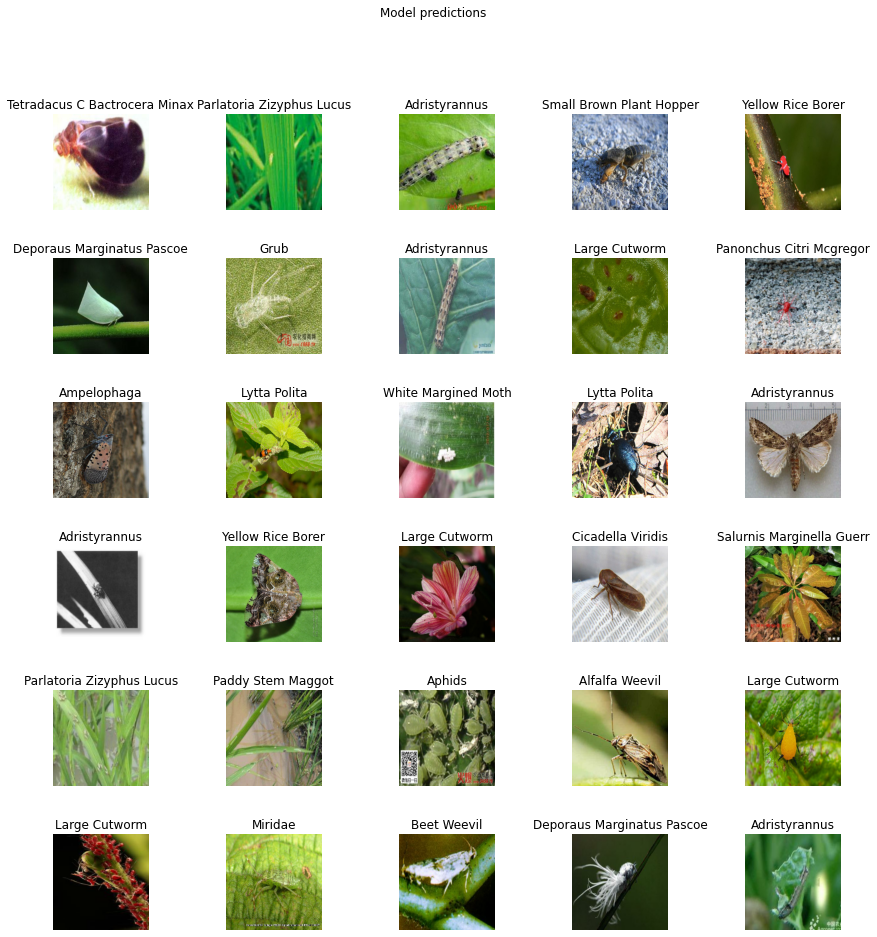

In [89]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"


In [ ]:
model.save(KERAS_MODEL_NAME)


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset,  class_names, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"


In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [ ]:
from distutils.util import convert_path


convert_path(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [132]:
model_name = 'mobilenet_v3'

saved_model_path = f"/tmp/saved_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_model_mobilenet_v3\assets


INFO:tensorflow:Assets written to: /tmp/saved_model_mobilenet_v3\assets


In [136]:
optimize_lite_model = True 
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/saved_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 4894824 bytes.


In [137]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [138]:
num_eval_examples = 50 
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TFLite model agrees with original model on 0 of 50 examples (0%).
TFLite model is accurate on 0 of 50 examples (0%).


In [5]:
python ./metadata_writer_for_image_classifier.py \
    --model_file=./model_without_metadata/mobilenet_v1_0.75_160_quantized.tflite \
    --label_file=./model_without_metadata/labels.txt \
    --export_directory=model_with_metadata

SyntaxError: invalid syntax (648065516.py, line 1)